In [28]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

In [29]:
net = nn.Sequential( 	# nn.Conv2d(in_channels,...),
									# activation fun,
									# dropout,
									# nn.Conv2d(in_channels,...),
									# activation fun,
									# dropout,
									## continue like above,
									## **define pooling (bonus)**,
									nn.Conv2d(1,64,4,1,1),
									nn.ReLU(),
									nn.MaxPool2d(2,2),
									
									nn.Conv2d(64,64,4,1,1),
									nn.ReLU(),
									nn.MaxPool2d(2,2),
									

									nn.Conv2d(64,64,4,1,1),
									nn.ReLU(),
									nn.MaxPool2d(2,2),

                  nn.Flatten()
								)

In [3]:
X = torch.randn(1, 1, 28, 28)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 64, 27, 27])
ReLU output shape:	 torch.Size([1, 64, 27, 27])
MaxPool2d output shape:	 torch.Size([1, 64, 13, 13])
Conv2d output shape:	 torch.Size([1, 64, 12, 12])
ReLU output shape:	 torch.Size([1, 64, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 64, 6, 6])
Conv2d output shape:	 torch.Size([1, 64, 5, 5])
ReLU output shape:	 torch.Size([1, 64, 5, 5])
MaxPool2d output shape:	 torch.Size([1, 64, 2, 2])
Flatten output shape:	 torch.Size([1, 256])


In [30]:
class CNNModel(nn.Module):
	"""docstring for ClassName"""
	
	def __init__(self, args):
		super(CNNModel, self).__init__()
		##-----------------------------------------------------------
		## define the model architecture here
		## MNIST image input size batch * 28 * 28 (one input channel)
		##-----------------------------------------------------------
		
		## define CNN layers below
		self.conv = nn.Sequential( 	# nn.Conv2d(in_channels,...),
									# activation fun,
									# dropout,
									# nn.Conv2d(in_channels,...),
									# activation fun,
									# dropout,
									## continue like above,
									## **define pooling (bonus)**,
									nn.Conv2d(1,64,4,1,1),
                  nn.BatchNorm2d(64),
									nn.ReLU(),
									nn.MaxPool2d(2,2),
									
									nn.Conv2d(64,64,4,1,1),
                  nn.BatchNorm2d(64),
									nn.ReLU(),
									nn.MaxPool2d(2,2),
									

									nn.Conv2d(64,64,4,1,1),
                  nn.BatchNorm2d(64),
									nn.ReLU(),
									nn.MaxPool2d(2,2),

								)

		##------------------------------------------------
		## write code to define fully connected layer below
		##------------------------------------------------
		in_size = 256
		out_size = 128
		self.fc = nn.Sequential(nn.Linear(in_size,out_size),
                            nn.BatchNorm1d(out_size),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(out_size,10)
                          )

		

	'''feed features to the model'''
	def forward(self, x):  #default
		
		##---------------------------------------------------------
		## write code to feed input features to the CNN models defined above
		##---------------------------------------------------------
		x_out = self.conv(x)

		## write flatten tensor code below (it is done)
		x = torch.flatten(x_out,1) # x_out is output of last layer
		

		## ---------------------------------------------------
		## write fully connected layer (Linear layer) below
		## ---------------------------------------------------
		result =  self.fc(x) # predict y
		
		
		return result
        

In [31]:
import argparse
import subprocess

'''
fun: convert string to boolean: True and False
'''
def str2bool(v):
    # codes from : https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse

    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
    

In [32]:
"""
Fun: CNN for MNIST classification
"""


import numpy as np
import time
import h5py
import argparse
import os.path
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from util import _create_batch
import json
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


In [33]:
## input hyper-paras
parser = argparse.ArgumentParser(description = "nueral networks")
parser.add_argument("-mode", dest="mode", type=str, default='train', help="train or test")
parser.add_argument("-num_epoches", dest="num_epoches", type=int, default=10, help="num of epoches")

# parser.add_argument("-fc_hidden1", dest="fc_hidden1", type=int, default=100, help="dim of hidden neurons")
# parser.add_argument("-fc_hidden2", dest="fc_hidden2", type=int, default=100, help="dim of hidden neurons")
parser.add_argument("-learning_rate", dest ="learning_rate", type=float, default=0.001, help = "learning rate")
parser.add_argument("-decay", dest ="decay", type=float, default=0.5, help = "learning rate")
parser.add_argument("-batch_size", dest="batch_size", type=int, default=200, help="batch size")
parser.add_argument("-dropout", dest ="dropout", type=float, default=0.4, help = "dropout prob")
parser.add_argument("-rotation", dest="rotation", type=int, default=10, help="image rotation")
parser.add_argument("-load_checkpoint", dest="load_checkpoint", type=str2bool, default=False, help="true of false")

parser.add_argument("-activation", dest="activation", type=str, default='relu', help="activation function")
# parser.add_argument("-MC", dest='MC', type=int, default=10, help="number of monte carlo")
parser.add_argument("-channel_out1", dest='channel_out1', type=int, default=64, help="number of channels")
parser.add_argument("-channel_out2", dest='channel_out2', type=int, default=64, help="number of channels")
parser.add_argument("-k_size", dest='k_size', type=int, default=4, help="size of filter")
parser.add_argument("-pooling_size", dest='pooling_size', type=int, default=2, help="size for max pooling")
parser.add_argument("-stride", dest='stride', type=int, default=1, help="stride for filter")
parser.add_argument("-max_stride", dest='max_stride', type=int, default=2, help="stride for max pooling")
parser.add_argument("-ckp_path", dest='ckp_path', type=str, default="checkpoint", help="path of checkpoint")

_StoreAction(option_strings=['-ckp_path'], dest='ckp_path', nargs=None, const=None, default='checkpoint', type=<class 'str'>, choices=None, help='path of checkpoint', metavar=None)

In [34]:
args, unknown = parser.parse_known_args()

In [35]:
def _load_data(DATA_PATH, batch_size):
	'''Data loader'''

	print("data_path: ", DATA_PATH)
	train_trans = transforms.Compose([transforms.RandomRotation(args.rotation),transforms.RandomHorizontalFlip(),\
								transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
	
	train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, download=True,train=True, transform=train_trans)
	train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=8)
	
	## for testing
	test_trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
	test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, download=True, train=False, transform=test_trans)
	test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
	
	return train_loader, test_loader


In [36]:
def _compute_accuracy(y_pred, y_batch):
	## --------------------------------------------
	## write the code of computing accuracy below
	## --------------------------------------------
	accy = np.sum(np.array(y_pred) == np.array(y_batch))/len(y_batch)
	return accy

In [37]:
def adjust_learning_rate(learning_rate, optimizer, epoch, decay):
	"""Sets the learning rate to the initial LR decayed by 1/10 every args.lr epochs"""
	lr = learning_rate
	if (epoch > 5):
		lr = 0.001
	if (epoch >= 10):
		lr = 0.0001
	if (epoch > 20):
		lr = 0.00001
	
	for param_group in optimizer.param_groups:
		param_group['lr'] = lr
	# print("learning_rate: ", lr)

In [38]:
def _save_checkpoint(ckp_path, model, epoches, optimizer, global_step):
	checkpoint = {'epoch':epoches,
					'global_step':global_step, #iterations
					'model_state_dict':model.state_dict(),
					'optimizer_state_dict':optimizer.state_dict()
					}
	torch.save(checkpoint, ckp_path)

def _load_checkpoint(ckp_path,model,optimizer):
	checkpoint = torch.load(ckp_path)
	# load parameters such as W and b to models
	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
	epoches = checkpoint['epoch']

In [39]:
def main():

  use_cuda = torch.cuda.is_available() ## if have gpu or cpu 
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    torch.cuda.set_device(device=0) ## choose gpu number 0
  print("device: ", device)
  if use_cuda:
    torch.cuda.manual_seed(72)

  ## initialize hyper-parameters
  num_epoches = args.num_epoches
  decay = args.decay
  learning_rate = args.learning_rate
  

  ## step 1: Load data
  DATA_PATH = "./data/"
  train_loader, test_loader=_load_data(DATA_PATH, args.batch_size)

  ##-------------------------------------------------------
  ## please write the code about model initialization below
  ##-------------------------------------------------------
  model = CNNModel(args) #kernel size, stride
  ## load model to gpu or cpu
  model.to(device)
  
  ## --------------------------------------------------
  ## Complete code about defining the LOSS FUNCTION
  ## --------------------------------------------------
  optimizer = optim.Adam(model.parameters(),lr=learning_rate)  ## optimizer
  loss_fun = nn.CrossEntropyLoss()  ## cross entropy loss
  
  ##--------------------------------------------
  ## load checkpoint below if you need
  ##--------------------------------------------
  if args.load_checkpoint:
    # write load checkpoint code below
    _load_checkpoint(args.ckp_path,model,optimizer)

  writer = SummaryWriter()
  iter = 0
  training_accs = []
  losses = []
  ##  model training
  if args.mode == 'train':
    model = model.train()
    for epoch in range(num_epoches): #10-50
      ## learning rate
      adjust_learning_rate(learning_rate, optimizer, epoch, decay)

      for batch_id, (x_batch,y_labels) in enumerate(train_loader):
        x_batch,y_labels = Variable(x_batch).to(device), Variable(y_labels).to(device)

        ## feed input data x into model
        output_y = model(x_batch)
        
        ##---------------------------------------------------
        ## write loss function below, refer to tutorial slides
        ##----------------------------------------------------
        loss =  loss_fun(output_y, y_labels)
        

        ##----------------------------------------
        ## write back propagation below
        ##----------------------------------------
        optimizer.zero_grad() # clear cache of gradients
        loss.backward()
        optimizer.step() # update params(Weights W and b)

        ##------------------------------------------------------
        ## get the predict result and then compute accuracy below
        ##------------------------------------------------------
        # _, y_pred = torch.max(output_y.data, 1)
        y_pred = torch.argmax(output_y.data, 1) # only return index
        accuracy = _compute_accuracy(y_pred, y_labels)
        training_accs.append(accuracy)
        if batch_id % 50 == 0:
          print("epoch:"+str(epoch)+" batch:"+str(batch_id)+" training accuray:"+str(accuracy))
        
        ##----------------------------------------------------------
        ## loss.item() or use tensorboard to monitor the loss blow
        ## if use loss.item(), you may use log txt files to save loss
        ##----------------------------------------------------------
        losses.append(loss.item())
        writer.add_scalar('Loss', loss, iter)
        iter += 1

      ## -------------------------------------------------------------------
      ## save checkpoint below (optional), every "epoch" save one checkpoint
      ## -------------------------------------------------------------------
      _save_checkpoint(args.ckp_path,model,epoch,optimizer,iter)
  writer.close()		
      
  ## Draw loss and accuracy fig
  x = range(1,len(training_accs)+1)
  plt.plot(x,training_accs,color='r',label="training accuracy")
  plt.plot(x,losses,color='g',label="loss")
  plt.xlabel("iteration")
  plt.show()

  ##------------------------------------
  ##    model testing code below
  ##------------------------------------
  model.eval()
  with torch.no_grad():
    test_accs=[]
    for batch_id, (x_batch,y_labels) in enumerate(test_loader):
      x_batch, y_labels = Variable(x_batch).to(device), Variable(y_labels).to(device)
      ##---------------------------------------
      ## write the predict result below
      ##---------------------------------------
      output_y = model(x_batch)
      y_pred = torch.argmax(output_y.data, 1) # only return index
        
      ##--------------------------------------------------
      ## complete code for computing the accuracy below
      ##---------------------------------------------------
      test_accs.append(_compute_accuracy(y_pred, y_labels))
  print("\n\n Overall Test Accuracy:"+str(np.average(test_accs[:-1])))


device:  cpu
data_path:  ./data/


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch:0 batch:0 training accuray:0.07
epoch:0 batch:50 training accuray:0.9
epoch:0 batch:100 training accuray:0.93
epoch:0 batch:150 training accuray:0.955
epoch:0 batch:200 training accuray:0.97
epoch:0 batch:250 training accuray:0.93
epoch:1 batch:0 training accuray:0.965
epoch:1 batch:50 training accuray:0.97
epoch:1 batch:100 training accuray:0.975
epoch:1 batch:150 training accuray:0.98
epoch:1 batch:200 training accuray:0.965
epoch:1 batch:250 training accuray:0.965
epoch:2 batch:0 training accuray:0.955
epoch:2 batch:50 training accuray:0.98
epoch:2 batch:100 training accuray:0.995
epoch:2 batch:150 training accuray:0.98
epoch:2 batch:200 training accuray:0.99
epoch:2 batch:250 training accuray:0.985
epoch:3 batch:0 training accuray:0.975
epoch:3 batch:50 training accuray:0.975
epoch:3 batch:100 training accuray:0.995
epoch:3 batch:150 training accuray:0.99
epoch:3 batch:200 training accuray:0.985
epoch:3 batch:250 training accuray:0.985
epoch:4 batch:0 training accuray:0.96
ep

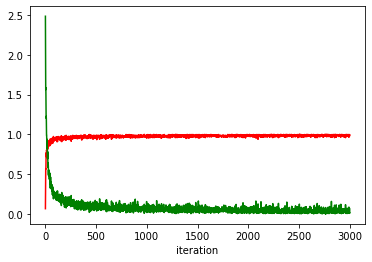



 Overall Test Accuracy:0.9881632653061226
running time:  28.81156431833903 mins


In [40]:
if __name__ == '__main__':
	time_start = time.time()
	main()
	time_end = time.time()
	print("running time: ", (time_end - time_start)/60.0, "mins")
	